# Synopsis

Create an LDA topic model from scratch using collapsed Gibbs Sampling.

# Configuration

In [174]:
src_file = '20news_01.csv'

In [175]:
n_docs = 100
n_topics = 15
n_iters = 100
alpha = 1
beta = 1

# Libraries

In [176]:
import pandas as pd
import numpy as np
import sqlite3
import re
import random
import textman as tx
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Pragmas

In [177]:
%matplotlib inline

# Process

## Get corpus from database

Grab an sample from the 20news corpus, which was generated from the SQLite database using the following query:
```sql
SELECT * 
FROM doc 
WHERE doc_label LIKE '%christian%' 
    OR doc_label LIKE '%baseball%' 
    OR doc_label LIKE '%politics%' 
    OR doc_label LIKE '%hardware%'
    OR doc_label LIKE '%hockey%'
ORDER BY RANDOM() 
LIMIT 100
```

In [179]:
docs = pd.read_csv(src_file, sep='\t')
docs = docs.set_index('doc_id')

In [180]:
docs.head()

,doc_label,doc_from,doc_subject,doc_content
doc_id,,,,
76209,talk.politics.mideast,jaa12@cunixa.cc.columbia.edu (John A Absood)\n,"Re: Hamza Salah, the Humanist\n",\nAre you people sure his posts are being forw...
51708,comp.sys.mac.hardware,ray@netcom.com (Ray Fischer)\n,Re: x86 ~= 680x0 ?? (How do they compare?)\n,\ndhk@ubbpc.uucp (Dave Kitabjian) writes ...\n...
60206,comp.sys.ibm.pc.hardware,tiger@netcom.com (Tiger Zhao)\n,Re: BusLogic 542B questions\n,\ngoyal@utdallas.edu (MOHIT K GOYAL) writes:\n...
54119,rec.sport.hockey,malinich@bucknell.edu (Tom Malinich)\n,Montreal Canadiens\n,\nAre there any Montreal Canadiens fans out th...
55086,talk.politics.guns,jmd@cube.handheld.com (Jim De Arras)\n,Re: CLINTON JOINS LIST OF GENOCIDAL SOCIALIST ...,\nIn article <16BB88F6D.R1328@vmcms.csuohio.ed...


### Show labels

Get a sense of what the corpus is about.

In [181]:
# docs.doc_label.value_counts()

## Convert corpus to tokens and vocab

We use a function from TextMan, a bespoke library that incorporates the text processing routines used in earlier notebooks.

In [182]:
tokens, vocab = tx.create_tokens_and_vocab(docs, src_col='doc_content')
tokens['token_num'] = tokens.groupby(['doc_id']).cumcount()
tokens = tokens.reset_index()[['doc_id','token_num','term_id']]
tokens = tokens[tokens.term_id.isin(vocab[vocab.go].index)]
tokens = tokens.set_index(['doc_id','token_num'])

### We add the term strings for convenience

In [183]:
tokens['term_str'] = tokens.term_id.map(vocab.term)

In [184]:
tokens.head()

term_id   term_str
doc_id token_num                    
76209  0             4557     people
       1             5848       sure
       2             4713      posts
       3             2671  forwarded
       4             5882     system

###  Remove redundant words

We actually *don't* do this because it ruins performance!

In [185]:
# tokens = tokens.reset_index().drop_duplicates(['doc_id','term_id']).set_index(['doc_id','token_num'])

In [186]:
# tokens.head()

## Remove insignificant words

We use SKlearn's TFIDF vectorizor to quicky get a TFIDF vector space, which we use only to filter the words in our corpus.

In [187]:
vectorizer = TfidfVectorizer(use_idf=1, stop_words='english', token_pattern=r'[A-Za-z][A-Za-z][A-Za-z]+')
X = vectorizer.fit_transform(docs.doc_content.values.tolist())
v = pd.DataFrame(vectorizer.get_feature_names(), columns=['term_str'])
v['idf'] = vectorizer.idf_

In [188]:
v.sort_values('idf', ascending=False).head(20)

,term_str,idf
0,aaa,4.921973
3491,nicely,4.921973
3488,nhlpa,4.921973
3486,nga,4.921973
3484,newswriter,4.921973
3483,newsweek,4.921973
3481,newspaper,4.921973
3480,newsgroups,4.921973
3478,newsbytes,4.921973
3476,newly,4.921973


### We take a look at the distribution of significance

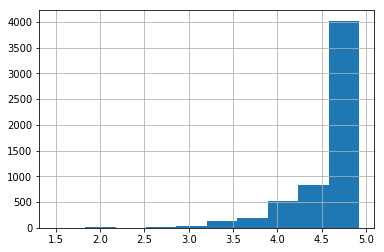

In [189]:
v.idf.hist()

### We take only the most significant words

In [190]:
cutoff = 4.5
v = v[v.idf > cutoff].sort_values('idf', ascending=False).sample(1000)
my_v = v.term_str.tolist()

In [193]:
# sorted(my_v)

In [194]:
tokens = tokens[tokens.term_str.isin(my_v)]

In [195]:
vocab = vocab[vocab.term.isin(my_v)]

## Create topics table

We will use this to collect information about topics, and in our sampling routine.

In [196]:
topics = pd.DataFrame(index=range(n_topics))
topics.index.name = 'topic_id'

## Define functions

### Randomly assign topics to tokens

In [197]:
def init_topics(tokens):
    tokens['topic_id'] = np.random.randint(0, n_topics, len(tokens))
    return tokens

In [198]:
# tokens = init_topics(tokens)

In [199]:
# tokens.head()

### Generate Count Matrices

In [200]:
def get_DT(tokens):
    return tokens.groupby(['doc_id','topic_id']).topic_id.count()\
        .unstack().fillna(0).astype('int')

In [201]:
def get_WT(tokens):
    return tokens.groupby(['topic_id','term_id']).term_id.count()\
        .unstack().fillna(0).astype('int').T

In [202]:
def get_DTP(dt):
    return (dt.T / dt.T.sum()).T

In [203]:
def get_WTP(wt):
    wtp = wt / wt.sum()
    wtp['term_str'] = vocab.term
    wtp = wtp.set_index('term_str')
    return wtp

In [204]:
def get_topic_seeds(wt):
    seeds = pd.DataFrame([(t, wt[t].sort_values().idxmax()) for t in range(n_topics)], columns=['t','w'])
    seeds = seeds.set_index('t')
    seeds['term_str'] = seeds.w.map(vocab.term)
    seeds = seeds.sort_values('term_str')
    return seeds

In [205]:
def get_doc_seeds(dt):
    seeds = pd.DataFrame([(d, DT.loc[d].idxmax()) for d in DT.index], columns=['d','t'])
    seeds = seeds.set_index('d')
    return seeds

In [206]:
def add_topic_info(topics, dt, wt, n_words = 7):
    dtp = get_DTP(dt)
    wtp = get_WTP(wt)
    topics['top_words'] = ''
    topics['top_words'] = topics.apply(lambda x: ' '.join(wtp[x.name].sort_values(ascending=False).head(n_words).index.values), 1)    
    topics['df_max'] = topics.apply(lambda x: dtp[x.name].max(), 1)
    topics['df_mean'] = topics.apply(lambda x: dtp[x.name].mean(), 1)
    topics['df_sum'] = topics.apply(lambda x: dtp[x.name].sum(), 1)
    topics['n_words'] = topics.apply(lambda x: wt[x.name].sum(), 1)
    return topics

### Print topics

In [207]:
def plot_topics(wtp, n=5):
    fig, axes = plt.subplots(nrows=n_topics, ncols=1, sharex=True)
    for t in range(n_topics):
        wtp[t].sort_values(ascending=True).tail(10).plot(kind='barh', ax=axes[t], figsize=(5,80))
        axes[t].set_title('Topic {}'.format(t))

## Use Collapsed Gibbs Sampling

See [this blog](http://brooksandrew.github.io/simpleblog/articles/latent-dirichlet-allocation-under-the-hood/).

Or, better, see [Griffiths 2002](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.138.3760).

### Define row function

In [208]:
def get_new_topic(row):
    
    d = row.name[0] # doc_id
    k = row.name[1] # token_num (not used)
    z = row.topic_id
    w = row.term_id
    
    DT.at[d,z] -= 1
    WT.at[w,z] -= 1
    
    p_z = DT.loc[d] * (WT.loc[w] / WT.sum())
    z_weights = p_z / p_z.sum()

    z1 = topics.sample(weights=z_weights).index.values[0]

    DT.at[d,z1] += 1
    WT.at[w,z1] += 1
    
    return z1

### Generate model

In [209]:
tokens = init_topics(tokens)
DT = get_DT(tokens) + alpha
WT = get_WT(tokens) + beta
topic_seeds = get_topic_seeds(WT)
doc_seeds = get_doc_seeds(WT)

In [210]:
topic_seeds

,w,term_str
t,,
11,1197,bos
5,1278,bryn
9,2039,desk
3,2044,det
6,2340,enact
2,2406,essence
4,2406,essence
0,2416,eternality
1,2594,fillibuster


In [211]:
doc_seeds.t.value_counts()

0     11
3     10
6      8
5      7
2      7
1      6
7      4
4      4
13     3
10     3
12     2
9      2
8      2
Name: t, dtype: int64

In [212]:
for i in range(n_iters):
    print(i, end=' ')
    tokens['topic_id'] = tokens.apply(get_new_topic, 1)
print('Done')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 Done


In [171]:
topics = add_topic_info(topics, DT, WT)

In [172]:
topics.top_words

topic_id
0     applicant bergen blacker boasberg budair bdsm ...
1     albury boneyard birger bouncy bonham arrhythmi...
2     basement badawi akaky bdsm bernstein araji bak...
3     anthem arrhythmia barfed bismarck campesinos b...
4     bonham bombastic boasberg birger bdsm blacker bct
5     campesinos bernstorff bdsm bismarck akaky albu...
6     berem bismarck baon boomer arvida berm bernstorff
7     assisted baddredine appropriations bernstein b...
8     brosse accessories asapov booga bombastic boas...
9       blaine asapov albury amazon berm araji bakewell
10      albania andsf app badawi bmps arvida campesinos
11    antimissile campesinos birger appropriations a...
12    amazon brosse budair bct astronaut bombastic a...
13    bazzi barfed brosse baddredine amad andsf astr...
14    broadband accessories albania amad bonham bct ...
Name: top_words, dtype: object

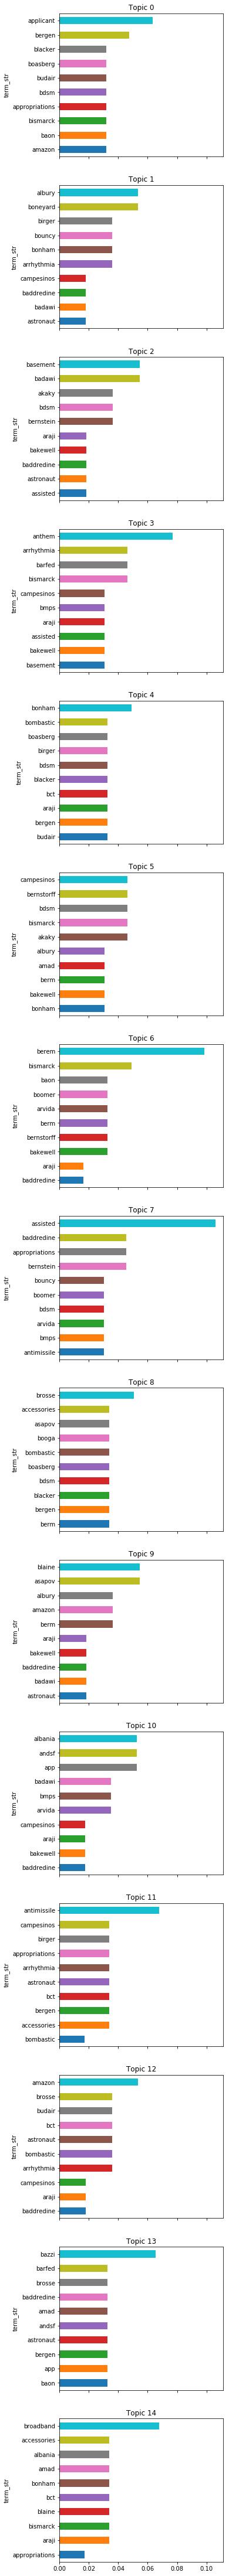

In [173]:
plot_topics(get_WTP(WT), 7)